# Analysis step by step

We provide here a step by step guide explaining how the different [code components](code_structure) to perform a complete analysis are used "under the hood" in case you want to re-use them or need a deeper understanding of the code.

## Dataset

We use here a synthetic dataset that simulates microscopy observation of a cell. You can find the dataset in [this folder](../snythetic/data) and has been generated using the [simulate_data](../synthetic/simulate_data.ipynb) notebook. The dataset is composed of 40 time points and three channels. A single cell starts as a circular object in the image center, and, over the 40 frames, the top cell edge moves upwards and downwards. The intensity in the first channel is homogeneous and is used for segmentation. In the two other channels, fluorescence is inhomogeneous and located at the cell bottom and also varies over time, including a time-shift between the second and third channels. The dataset is available [here](../synthetic/data) and has already been annotated and processed in ilastik with the result stored [here](../synthetic/data/Results_ilastik/segmented).


## morphosegmentation.dataset

The first step is to create a dataset object. For that we import the appropriate format from the module, in this case H5.

In [2]:
from morphodynamics.dataset import H5

Then we need to specify the location of the dataset:

In [3]:
expdir = '../synthetic/data'

and specify which channels we intend to use. We need to provide the name of the stack used for segmentation:

In [4]:
morpho_name = 'synth_ch1.h5'

as well as a list of stack names whose intensity we want to analyze:

In [5]:
signal_name = ['synth_ch2.h5','synth_ch3.h5']

Now we can create our dataset using the H5 object:

In [6]:
data = H5(
    expdir=expdir,
    signal_name=signal_name,
    morpho_name=morpho_name,
)


The data object has several attributed and methods attached. For example we can import the images of the segmentation channel signal channels at time 8:

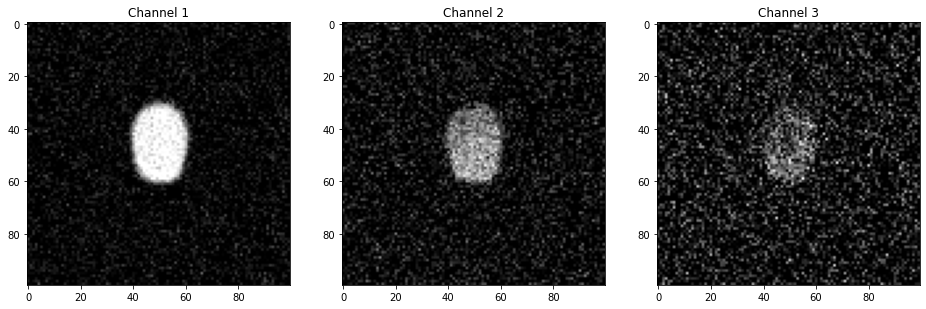

In [14]:
import matplotlib.pyplot as plt

time = 8
image1 = data.load_frame_morpho(time)
image2 = data.load_frame_signal(0, time)
image3 = data.load_frame_signal(1, time)
fig, ax = plt.subplots(1, 3, figsize=(16,5))
ax[0].imshow(image1, cmap = 'gray')
ax[0].set_title('Channel 1')
ax[1].imshow(image2, cmap = 'gray')
ax[1].set_title('Channel 2')
ax[2].imshow(image3, cmap = 'gray')
ax[2].set_title('Channel 3');

## Preparation steps
We want to save the output of our analysis in a new results folder. We create it and then also copy the results of the ilastik segmentation there in a ```segmented``` subfolder.

In [16]:
from pathlib import Path
import os
import shutil
import numpy as np

ilastik_path = Path("data/Results_ilastik/segmented")
target_path = Path("data/Results_step/segmented")
if not target_path.is_dir():
    target_path.mkdir(parents=True)
files = list(ilastik_path.glob('segmented*'))
moved = [shutil.copyfile(f, target_path.joinpath(f.name)) for f in files]

## Set-up parameters for analysis

Now we create a Param object where we store parameters for our segmentation:

In [17]:
from morphodynamics.parameters import Param

result_dir = '../synthetic/data/Results_step'

param = Param(expdir=expdir, morpho_name=morpho_name, signal_name=signal_name,
             resultdir=result_dir)
param.width = 5
param.depth = 5
param.seg_algo = 'ilastik'

## Calibrate number of windows and cell location

Now we can finally run the analysis. In a first step, we need to estimate into how many layers (```J```) and how many windows per layer (```I```) our cell should be split based on the desired width and depth of a window. Here we also determine the center of mass position of the cell (```location```):

In [19]:
from morphodynamics.analysis_par import calibration, segment_all

location, J, I = calibration(data, param, model=None)

In [24]:
print(f'cell location: {location}')
print(f'number of windows per layer I: {I}')
print(f'number of layer J: {J}')

cell location: (49.27272727272727, 49.86753246753247)
number of windows per layer I: [16, 9]
number of layer J: 2


## Set-up results structure

We also need to setup a data structure to save some output information such as windowing information (which pixels belong to which window) or signal per window values. For that we use the ```Results``` structure from the ```morphodynamics.results``` module. To create "empty" fields we need to know the numebr of windows, time points and signal channels:

In [25]:
from morphodynamics.results import Results
# Result structures that will be saved to disk
res = Results(
    J=J, I=I, num_time_points=data.K, num_channels=len(data.signalfile)
)

## Start dask

To make computation faster, the slow parts of the code are executed in parallel using the library Dask. One of the great advantages of that library is that it allows to seamlessly run the same code on a laptop and a cluster:

In [26]:
from dask.distributed import Client
client = Client()

## Segmentation

The first step of the pipeline is the cell segmentation. As we are using the ilastik pre-segmentation this step is automatically skipped here:

In [27]:
# Segment all images but don't select cell
if param.seg_algo == 'ilastik':
    segmented = np.arange(0, data.K)
else:
    segmented = segment_all(data, param, client, model=None)

## Tracking

We might have multiple cell in a field of view so that our segmentation output is not a simple binary mask but a labeled mask with multiple cells. We therefore have to decide which cell to consider. This can be done in the UI by picking a point in the image or by manually indicating the x-y location of a cell. Here we only have a single cell, so that selection is automatic. Once a cell has been selected in the first frame, we can track it across frames. This part of the analysis cannot be parallelized as the cell has to be tracked in successive frames:

In [28]:
from morphodynamics.analysis_par import track_all
# do the tracking
segmented = track_all(segmented, location, param)

The output of the tracking is stored as a series of binary masks names ```tracked_k_0.tif```, ```tracked_k_1.tif``` etc.

## Splining

Now that we have binary masks, we can analyze their contour and fit a spline function to them. The spline information is also stored in the ```res``` structure to avoid the need for recalculation. Here ```s_all``` is a dictionary with frames as keys and containing the spline information.

In [29]:
from morphodynamics.analysis_par import spline_all
# get all splines
s_all = spline_all(data.K, param.lambda_, param, client)

frames splining: 100%|██████████| 40/40 [00:10<00:00,  3.81it/s]


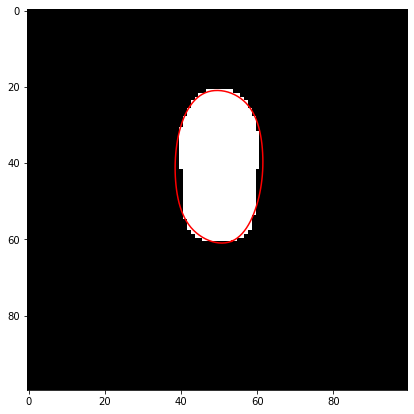

In [46]:
import skimage.io
from morphodynamics.displacementestimation import splevper

frame = 20
tracked_image = skimage.io.imread('../synthetic/data/Results_step/segmented/tracked_k_'+str(20)+'.tif')
splined = splevper(np.linspace(0,1,100), s_all[frame])

fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(tracked_image, cmap='gray')
ax.plot(splined[0], splined[1], 'r');

## Aligning splines and creating rasterized images

Given all the splines, we need now to align them to account for x-y shifts (e.g. if the cell is moving) and shifts of the spline along the contour. Once the alignment is done, we can create a rasterized version of the contour, i.e. an image of the contour where the pixel value corresponds to the curvilinear distance from the spline origin. This is late used to create windows.

The aligned splines are saved in ```s0prm_all``` and the shift in origin in ```ori_all```.

In [48]:
from morphodynamics.analysis_par import align_all
# align curves across frames and rasterize the windows
s0prm_all, ori_all = align_all(
    s_all, data.shape, param.n_curve, param, client
)

frames rasterize: 100%|██████████| 40/40 [00:01<00:00, 21.14it/s]


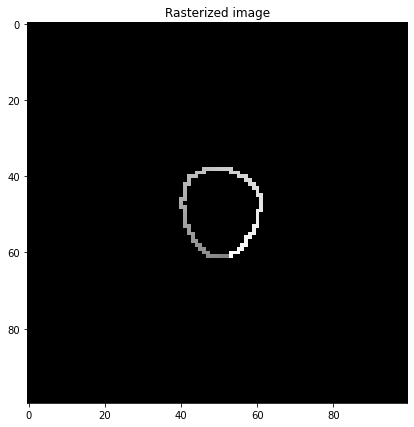

In [49]:
raster_image = skimage.io.imread('../synthetic/data/Results_step/segmented/rasterized_k_0.tif')
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(raster_image, cmap = 'gray')
ax.set_title('Rasterized image');

As we calculate the spline origin shift between pairs of successive frames (so that the operation can be parallelized), we need to calculate a cumulative sum to recover the shift between frame 0 and frame ```f```:

In [50]:
# origin shifts have been computed pair-wise. Calculate the cumulative
# sum to get a "true" alignment on the first frame
res.orig = np.array([ori_all[k] for k in range(data.K)])
res.orig = np.cumsum(res.orig)

## Window mapping

The aligned splines and the rasterized images (made with the aligned splines) can now be used to:
1. Create windows for each time point
2. Find optimal points along successive splines to minimize some deformation metric.

It is important to mention here that the windows are **not** adjusted using that optimization. Windows are simply calculated based on splines that have been shift-corrected (x-y) and "curvilinear"-corrected so that they have matching positions. On the other side the displacement is calculated by optimizing the location of points on the spline of frame = t+1 compared to *windows positions* at frame = t.

In [51]:
from morphodynamics.analysis_par import window_map_all, window_map_and_save
# define windows for each frame and compute pairs of corresponding
# points on successive splines for displacement measurement
t_all, t0_all = window_map_all(
    s_all,
    s0prm_all,
    J,
    I,
    res.orig,
    param.n_curve,
    data.shape,
    param,
    client
)

frames compute windows: 100%|██████████| 40/40 [00:02<00:00, 16.99it/s]


## Extracting signals

In a final step, we used calculate the mean and standard deviation of the signal present in all calculated windows. We can also now compute the actual "optimized" displacement between successive frames. All these results are saved in the ```res``` structure.

In [52]:
from morphodynamics.analysis_par import extract_signal_all, compute_displacement

# Signals extracted from various imaging channels
mean_signal, var_signal = extract_signal_all(data, param, J, I)

# compute displacements
res.displacement = compute_displacement(s_all, t_all, t0_all)

# Save variables for archival
res.spline = [s_all[k] for k in range(data.K)]
res.param0 = [t0_all[k] for k in t0_all]
res.param = [t_all[k] for k in t_all]
res.mean = mean_signal
res.var = var_signal

## Check results

We can have a look at the results to estimate if everything worked as expected. 

In [55]:
import pickle
import skimage.io

t = 0

name = os.path.join(
    param.resultdir,
    "segmented",
    "window_image_k_" + str(t) + ".tif",
)
image = data.load_frame_morpho(t)

In [56]:
b0 = skimage.io.imread(name)
b0 = b0.astype(float)
b0[b0 == 0] = np.nan

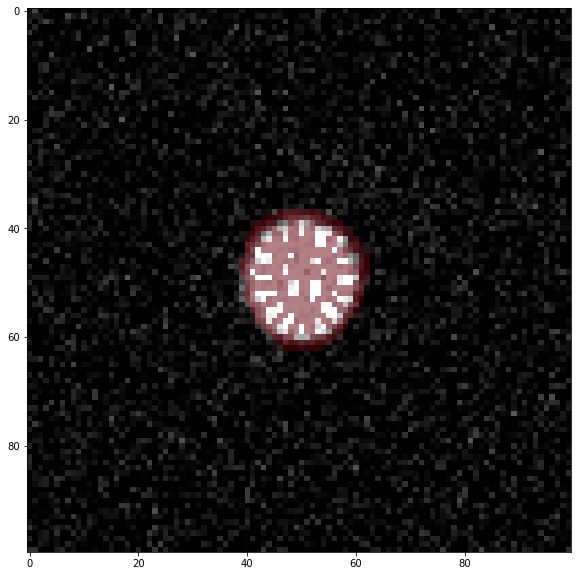

In [66]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(image, cmap='gray')
ax.imshow(b0, alpha = 0.5, cmap='Reds',vmin=0,vmax=0.5);